# **XAI W6 Assignment**

**California Housing Dataset**: Contains features like median income, house age, average rooms, and others to predict housing prices.


---


**XGBoost Regression Mode**l: A high-performance model using gradient boosting to improve predictions and handle large datasets.


In [ ]:
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/purplevjs/XAI_W6.git)


SyntaxError: invalid decimal literal (<ipython-input-47-aa40f0504fe4>, line 1)

In [ ]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install alibi

In [ ]:
!pip install pdpbox

In [ ]:
!pip install --upgrade pdpbox

In [ ]:
!pip install xgboost pdpbox alepython

ERROR: Could not find a version that satisfies the requirement alepython (from versions: none)
ERROR: No matching distribution found for alepython


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import pdpbox
from pdpbox import pdp, info_plots

In [ ]:
# Loading California Housing Dataset
housing = fetch_california_housing()

housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['Price'] = housing.target

housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


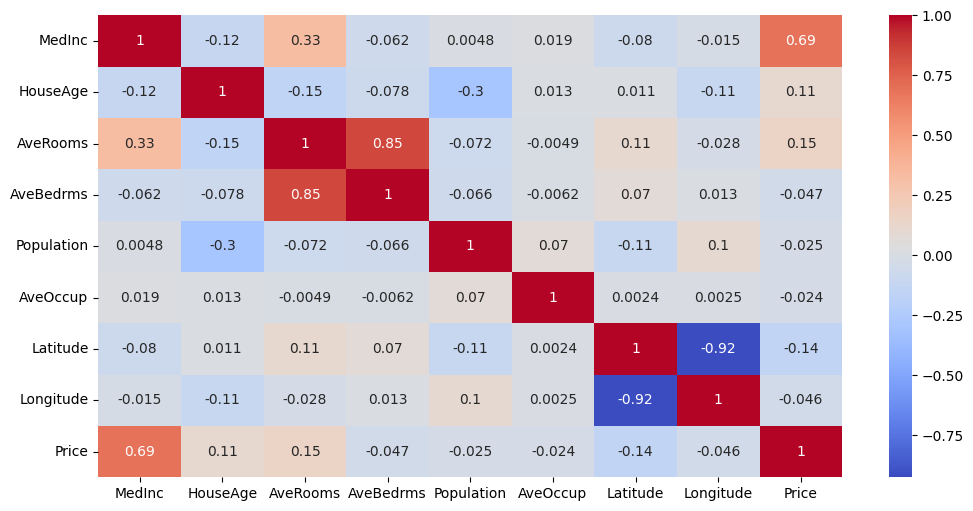

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(housing_df.corr(), annot=True, cmap = 'coolwarm')
plt.show()

- MedInc and Price show a strong positive correlation (0.69), suggesting that higher median income is associated with higher house prices.
- Latitude and Longitude have a strong negative correlation (-0.92), reflecting a significant geographic relationship between these two coordinates.

In [ ]:
# Separate features (X) and target (y)
X = housing_df.drop('Price', axis=1)
y = housing_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# model
model = XGBRegressor().fit(X_train, y_train)

### Partial Dependence Plots (PDP)

- A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model

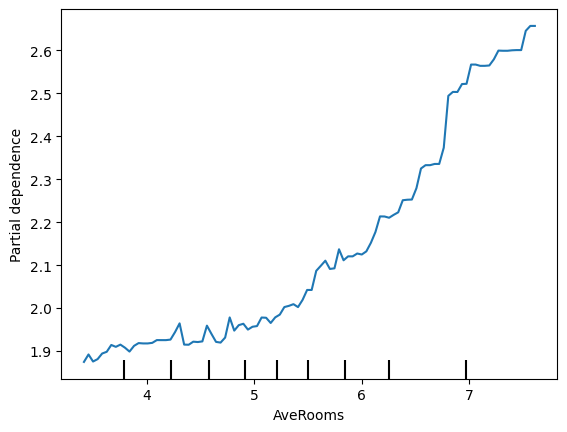

In [ ]:
features = ['AveRooms']
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average')

- The partial dependence increases steadily with the number of rooms, indicating a positive relationship between AveRooms and the predicted house price.
- Around 6 rooms, the graph shows a sharper increase, suggesting that houses with more rooms significantly impact the model’s predictions.

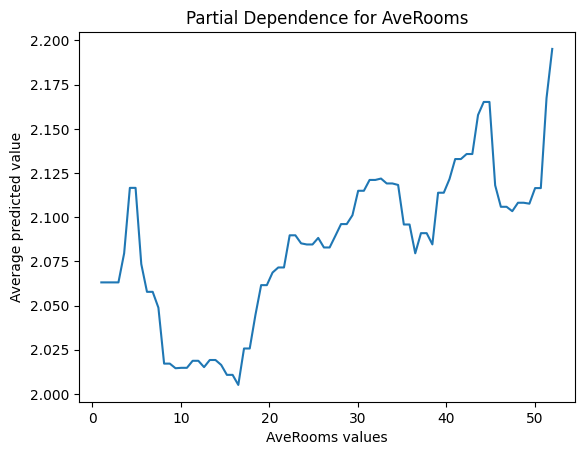

In [ ]:
# Using numpy
feature_index = 1

feature_values = np.linspace(np.min(X_train.iloc[:, feature_index]), np.max(X_train.iloc[:, feature_index]), num=80)

avg_preds = np.zeros_like(feature_values)

X_modified = X_train.copy()

for i, value in enumerate(feature_values):
  X_modified.iloc[:, feature_index] = value
  preds = model.predict(X_modified)
  avg_preds[i] = np.mean(preds)


plt.plot(feature_values, avg_preds)
plt.xlabel('AveRooms values')
plt.ylabel('Average predicted value')
plt.title('Partial Dependence for AveRooms')
plt.show()

- This graph covers a wider range of AveRooms values (up to 50) and shows more fluctuation in predicted values compared to the steady rise in the previous graph.

### ALE
- A technique used to understand how small changes in a feature affect a model's predictions at a local level. It offers a clearer view of feature importance compared to PDP, particularly when features interact or have non-linear relationships.

array([[<Axes: xlabel='AveRooms', ylabel='ALE'>]], dtype=object)

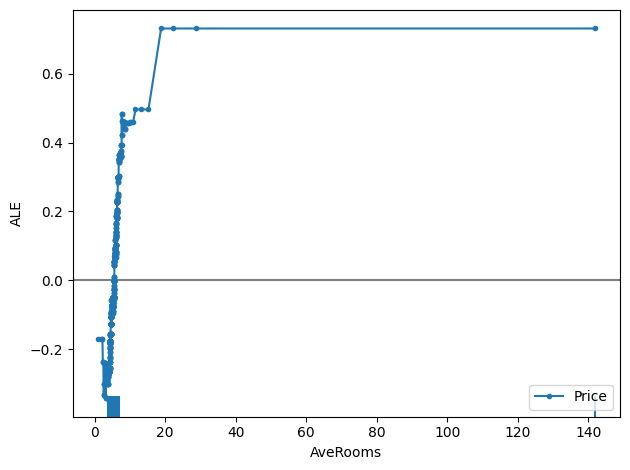

In [ ]:
feature_names = X_train.columns.tolist()
ale = ALE(model.predict, feature_names=feature_names, target_names=['Price'])
exp = ale.explain(X_train.to_numpy())

plot_ale(exp, features=[2])


- This graph covers a wider range of AveRooms values (up to 50) and shows more fluctuation in predicted values compared to the steady rise in the previous graph.
- Negative ALE for very low room counts: Households with fewer than 5 rooms have a slightly negative effect on predicted prices.

#### Difference between PDP and ALE
- Handling Feature Correlations:  
  - PDP: When plotting AveRooms, PDP will show a general trend of how changes in AveRooms affect the Price. However, it assumes that other features (even if not included) remain constant, which can oversimplify the relationship.
  - ALE: ALE focuses on localized changes, showing how small adjustments to AveRooms impact Price. It provides a more accurate depiction by focusing on how the average number of rooms affects Price at different local values.  

- Interpretation of Effects:
  - PDP: For AveRooms, the PDP might show a smooth curve suggesting that as the number of rooms increases, prices consistently rise. This can overstate the effect by averaging over the whole dataset.
  - ALE: ALE might reveal more nuanced effects, such as a sharp increase in prices at lower room counts (e.g., below 4 rooms) and a plateau or slower growth for houses with more rooms. It provides a clearer understanding of AveRooms’ impact at different points.



### ICE

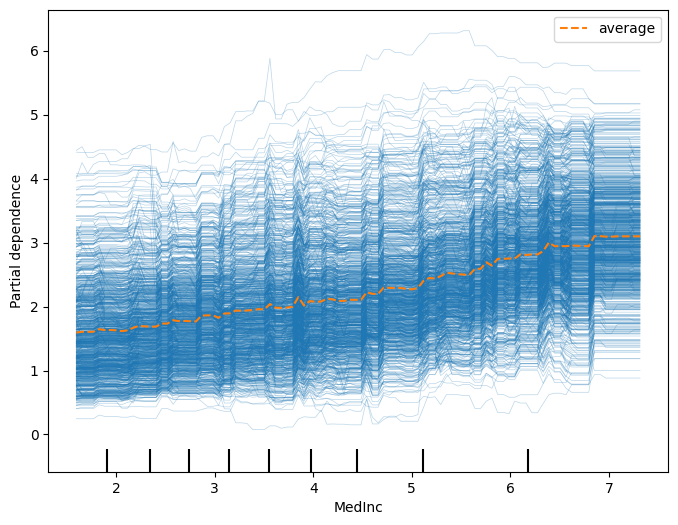

In [ ]:
# Generate both PDP and ICE for 'MedInc'
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=['MedInc'],
    kind='both',
    ax=ax
)

plt.show()

- As MedInc increases, the partial dependence (model prediction) tends to increase, indicating a positive relationship between median income and the target variable.
- Blue lines (ICE curves): Each line represents an Individual Conditional Expectation (ICE) curve for one observation, showing how the model's prediction changes with varying MedInc for each instance.